<a href="https://colab.research.google.com/github/Pankaj1357/HC18-Grand-Challenge/blob/master/HC18.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
# Run this cell to mount your Google Drive.
from google.colab import drive
drive.mount('/content/drive', force_remount = True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
## this is to install and import pydrive utilities to help us download our data to colab from google drive
!pip install -U -q PyDrive

from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

     |████████████████████████████████| 993kB 44.8MB/s 


In [0]:
# this is form authentication of user
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [0]:
## we are downloading file from Google drive to our colab environment
## this is just a empty folder to put our segmentation mask results

file_id = '1EaWui3uYpgfa1mEReU8jtO9WOG4U3TEw'          ## at the end of google drive shareble link
downloaded_0 = drive.CreateFile({'id': file_id})
downloaded_0.GetContentFile('segmented.zip')
!unzip segmented.zip # unzipping the zipped file

Archive:  segmented.zip
   creating: segmented/


In [0]:
# out dataset downloaded
# this folder have train and test data

file_id = '1yEnyA83FwGQtrW3exYoldp8elV2d2QtA'          ## at the end of google drive shareble link
downloaded_1 = drive.CreateFile({'id': file_id})
downloaded_1.GetContentFile('HC18-20190711T100842Z-001.zip')
!unzip HC18-20190711T100842Z-001.zip

Archive:  HC18-20190711T100842Z-001.zip
  inflating: HC18/training_set_pixel_size_and_HC.csv  
  inflating: HC18/test_set_pixel_size.csv  
  inflating: HC18/training_set/801_HC_Annotation.png  
  inflating: HC18/training_set/795_2HC_Annotation.png  
  inflating: HC18/training_set/804_HC_Annotation.png  
  inflating: HC18/training_set/805_HC_Annotation.png  
  inflating: HC18/training_set/794_HC_Annotation.png  
  inflating: HC18/training_set/795_HC_Annotation.png  
  inflating: HC18/training_set/126_HC.png  
  inflating: HC18/training_set/793_HC_Annotation.png  
  inflating: HC18/training_set/803_HC_Annotation.png  
  inflating: HC18/training_set/802_HC_Annotation.png  
  inflating: HC18/training_set/800_HC_Annotation.png  
  inflating: HC18/training_set/793_2HC_Annotation.png  
  inflating: HC18/training_set/798_HC_Annotation.png  
  inflating: HC18/training_set/792_HC_Annotation.png  
  inflating: HC18/training_set/791_HC_Annotation.png  
  inflating: HC18/training_set/797_HC_Annotat

In [0]:
import cv2
import os
import matplotlib.pyplot as plt
import pandas as pd

# **Mask Generation**
Done only once and replaced that  annotation with masks permanently
Did not changed the annotation file name though

## **Warning!!!**
Do not run below cells as task is already completed

In [0]:
train_pixel_file = pd.read_csv('/content/HC18/training_set_pixel_size_and_HC.csv')
train_pixel_file.head()
# This Dataframe will be used to extract image names hence by doing image_name + '_Annotation' we will get annotation names

,filename,pixel size(mm),head circumference (mm)
0,000_HC.png,0.069136,44.30
1,001_HC.png,0.089659,56.81
2,002_HC.png,0.062033,68.75
3,003_HC.png,0.091291,69.00
4,004_HC.png,0.061240,59.81


In [0]:
# This function takes annotation and spits out corresponding mask
def masking(image):
    imgray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    ret, thresh = cv2.threshold(imgray, 127, 255, 0)
    useless0,contours, useless1 = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    ellipse = cv2.fitEllipse(contours[0])
    return cv2.ellipse(image, ellipse, (255,255,255), -1)

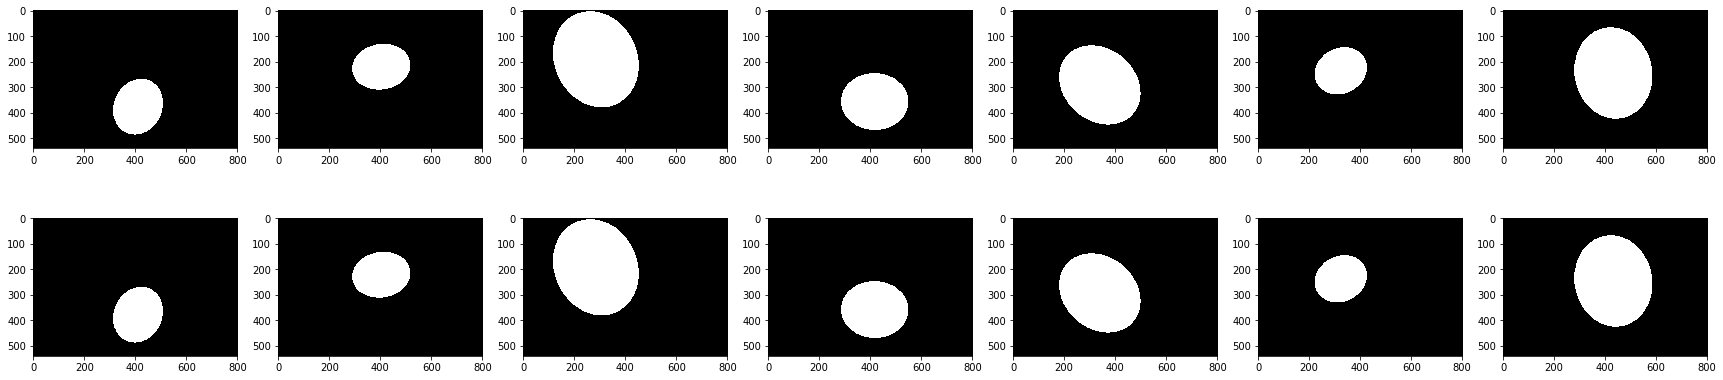

In [0]:
# to check if our masking function is working correctly
fig = plt.figure(figsize = (30,7))
for index in range(7):
  file_path = os.path.join('/content/HC18/training_set', train_pixel_file.iloc[index, 0].replace('.png','_Annotation.png'))
  #print(file_path)
  ax = fig.add_subplot(2, 7, index+1)             ## annoted plot
  plt.imshow(cv2.imread(file_path))
    
  ax = fig.add_subplot(2, 7, index+8)
  plt.imshow(masking(cv2.imread(file_path)))        ## mask plot

In [0]:
# Here we loop through training set and  take annotations one by one and replace them with corresponding masks
for index in range(len(train_pixel_file)):
    file_path = os.path.join('/content/drive/My Drive/HC18/training_set', train_pixel_file.iloc[index, 0].replace('.png','_Annotation.png'))
    image = cv2.imread(file_path)
    mask = masking(image)
    cv2.imwrite(file_path, mask)

## **Warning!!!**
**Done with mask generation. Don't run above cells ever again**

### **Do all the imports in below cell**

In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

from skimage import io, color
from PIL import Image
import cv2

import os
import random

import torch
from torch.utils.data  import Dataset, DataLoader
from torchvision import transforms
import torchvision.transforms.functional as TF
import torch.nn as nn
import torch.nn.functional as F
import torchvision

In [0]:
validation_set_size = 0.30            # fraction of dataset used for validation which will be splited randomly

In [0]:
# our dataset class
class HC18(Dataset):
  #""" train and validation dataset class"""
    def __init__(self, root_dir, train = True, transformX = None, transformY = None):
        self.pixel_file = pd.read_csv(os.path.join(root_dir, 'training_set_pixel_size_and_HC.csv'))
        self.root_dir = root_dir
        self.transformX = transformX
        self.transformY = transformY
        self.train = train
        
        # lets split the dataset in train and validation
        self.train_data, self.validation_data = train_test_split(self.pixel_file, test_size = validation_set_size, random_state = 5)
        
    def __len__(self):
        
        if self.train:
          length = len(self.train_data)
        else:
          length = len(self.validation_data)
        return length
    
    def __getitem__(self, index):
      
        if self.train:
          imx_name = os.path.join(self.root_dir, 'training_set', self.train_data.iloc[index, 0])
          imy_name = os.path.join(self.root_dir, 'training_set',self.train_data.iloc[index, 0].replace('.png','_Annotation.png'))

        else:
          imx_name = os.path.join(self.root_dir, 'training_set', self.validation_data.iloc[index, 0])
          imy_name = os.path.join(self.root_dir, 'training_set',self.validation_data.iloc[index, 0].replace('.png','_Annotation.png'))
        
        
        imx = Image.open(imx_name)
        imy = Image.open(imy_name).convert('L')
        
        ## tried some data augmentation techniques
        if self.train:
          # Random horizontal flipping
          if random.random() > 0.5:
              imx = TF.hflip(imx)
              imy = TF.hflip(imy)

          # Random vertical flipping
          if random.random() > 0.5:
              imx = TF.vflip(imx)
              imy = TF.vflip(imy)


          # Random rotation
          if random.random() > 0.8:
            angle = random.choice([-30, -90, -60, -45 -15, 0, 15, 30, 45, 60, 90])
            imx = TF.rotate(imx, angle)
            imy = TF.rotate(imy, angle)
        
        
        
        
        
        
        if self.transformX :
            imx = self.transformX(imx)
            imy = self.transformY(imy)
        
        sample = {'image': imx, 'annotation': imy}
        return sample

In [0]:
# our datasets
tx_X = transforms.Compose([ transforms.Resize((572, 572)),
                              transforms.ToTensor(),
                              transforms.Normalize((0.5,), (0.5,))
                              ])
tx_Y = transforms.Compose([ transforms.Resize((572, 572)),
                              transforms.ToTensor(),
                             # transforms.Normalize((0.5,), (0.5,))
                              ])
train_data = HC18('/content/HC18', train = True, transformX = tx_X, transformY = tx_Y)
validation_data = HC18('/content/HC18', train = False, transformX = tx_X, transformY = tx_Y )

In [0]:
# our dataloaders
train_loader = DataLoader(dataset = train_data, batch_size = 2, shuffle = True, num_workers = 2 )
validation_loader = DataLoader(dataset = validation_data, batch_size = 2, shuffle = True, num_workers = 2)

In [0]:
# this function will return numpy array from the transformed tensors which were
# obtained from our train_loader. Just to plot them and see if they are intact :) ha ha
def im_converterX(tensor):
    image = tensor.cpu().clone().detach().numpy() # make copy of tensor and converting it to numpy as we will need original later
    image = image.transpose(1,2,0) # swapping axes making (1, 28, 28) image to a (28, 28, 1)
 # print(image.shape)
    image = image * np.array((0.5, 0.5, 0.5)) + np.array((0.5, 0.5, 0.5)) # unnormalizing the image # this also outputs (28, 28, 3) which seems important for plt.imshow
    image = image.clip(0, 1) # to make sure final values are in range 0 to 1 as .ToTensor outputed
    return image

In [0]:
# this function will return numpy array from the transformed tensors which were
# obtained from our train_loader. Just to plot them and see if they are intact :) ha ha
def im_converterY(tensor):
    image = tensor.cpu().clone().detach().numpy() # make copy of tensor and converting it to numpy as we will need original later
    image = image.transpose(1,2,0) # swapping axes making (1, 28, 28) image to a (28, 28, 1)
 # print(image.shape)
    image = image * np.array((1, 1, 1)) # unnormalizing the image  not needed# this also outputs (28, 28, 3) which seems important for plt.imshow
    image = image.clip(0, 1) # to make sure final values are in range 0 to 1 as .ToTensor outputed
    return image

0 torch.Size([2, 1, 572, 572]) torch.Size([2, 1, 572, 572])


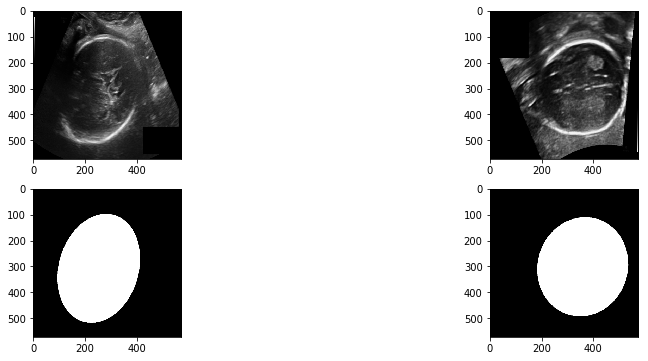

In [0]:
## Here we loop through our train_loader and see the images
## Looks good
fig = plt.figure(figsize = (15,6))
for ith_batch, sample_batched in enumerate(train_loader):
    print(ith_batch, sample_batched['image'].size(), sample_batched['annotation'].size())
    
    for index in range(2):
        ax = fig.add_subplot(2, 2 , index + 1)  # subplot index starts from 1
        plt.imshow(im_converterX(sample_batched['image'][index]))
        ax = fig.add_subplot(2, 2, index + 3)
        plt.imshow(im_converterY(sample_batched['annotation'][index]))
    break

In [0]:
class double_conv(nn.Module):
    '''(conv => BN => ReLU) * 2'''

    def __init__(self, in_ch, out_ch):
        super(double_conv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            #nn.Dropout2d(0.7),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            #nn.Dropout2d(0.77),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        x = self.conv(x)
        return x


class inconv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(inconv, self).__init__()
        self.conv = double_conv(in_ch, out_ch)

    def forward(self, x):
        x = self.conv(x)
        return x


class down(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(down, self).__init__()
        self.mpconv = nn.Sequential(
            nn.MaxPool2d(2),
            double_conv(in_ch, out_ch)
        )

    def forward(self, x):
        x = self.mpconv(x)
        return x


class up(nn.Module):
    def __init__(self, in_ch, out_ch, bilinear=True):
        super(up, self).__init__()

        if bilinear: #upsampling will not be learnable
            self.up = nn.Upsample(
                scale_factor=2, mode='bilinear', align_corners=True)
        else:  # it will be learnable here
            self.up = nn.ConvTranspose2d(in_ch // 2, in_ch // 2, 2, stride=2)

        self.conv = double_conv(in_ch, out_ch)

    def forward(self, x1, x2):
        x1 = self.up(x1)

        # input is CHW
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, (diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2))

        # for padding issues, see
        # https://github.com/HaiyongJiang/U-Net-Pytorch-Unstructured-Buggy/commit/0e854509c2cea854e247a9c615f175f76fbb2e3a
        # https://github.com/xiaopeng-liao/Pytorch-UNet/commit/8ebac70e633bac59fc22bb5195e513d5832fb3bd

        x = torch.cat([x2, x1], dim=1)
        x = self.conv(x)
        return x


class outconv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(outconv, self).__init__()
        self.conv = nn.Conv2d(in_ch, out_ch, 1)

    def forward(self, x):
        x = self.conv(x)
        return x

In [0]:
class UNet(nn.Module):
    def __init__(self, n_channels, n_classes):
        super(UNet, self).__init__()
        self.inc = inconv(n_channels, 64)
        self.down1 = down(64, 128)
        self.down2 = down(128, 256)
        self.down3 = down(256, 512)
        self.down4 = down(512, 512)
        self.up1 = up(1024, 256, bilinear = False) # upsampling weights are made learnable
        self.up2 = up(512, 128, bilinear = False)
        self.up3 = up(256, 64, bilinear = False)
        self.up4 = up(128, 64, bilinear = False)
        self.outc = outconv(64, n_classes)
        self.dropout = torch.nn.Dropout2d(0.5)

    def forward(self, x):
        x = x.float()
        x1 = self.inc(x)
        x2 = self.down1(x1)
       # x2 = self.dropout(x2) ##
        x3 = self.down2(x2)
        x4 = self.down3(x3)
       # x4 = self.dropout(x4)  #
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        #x = self.dropout(x)  #
        x = self.up3(x, x2)
        #x = self.dropout(x) #
        x = self.up4(x, x1)
        x = self.outc(x)
        return torch.sigmoid(x)
      
      
      
      
      
      
model = UNet(1, 1)
model.to('cuda')
print("Model Loaded to GPU")

Model Loaded to GPU


In [0]:
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters())

In [0]:
# calculates similarity index between predicted and actual segmentation
def dice_index(y_pred, y_actual):
    smooth = 0.000001
    size_of_batch = y_pred.size(0)
    
    p1 = y_pred.view(size_of_batch, -1)
    p2 = y_actual.view(size_of_batch, -1)
    
    intersection = (p1 * p2).sum()
    
    dice =  ((2.0 * intersection )+ smooth) / (p1.sum() + p2.sum() + smooth)
    #dice.requires_grad = True
    
    return dice

In [0]:
# calculate dice loss which will be later used in loss function calculation
def dice_loss(y_predict, y_train): ## to add in bce looss
  
  dice_loss = - torch.log(dice_index(y_predict, y_train))
  
  return dice_loss
  

In [0]:
epochs = 10


train_running_loss_history = []
validation_running_loss_history =[]

for e in range(epochs):
  train_running_loss = 0.0
  validation_running_loss = 0.0
  
  model.train()
  
  for ith_batch, sample_batched in enumerate(train_loader):
    X_train = sample_batched['image'].to('cuda')
    y_train = sample_batched['annotation'].to('cuda')
    
    #X_train.requires_grad = True
    #y_train.requires_grad = True

    #print(ith_batch) #, X_train.size(), y_train.size())

    optimizer.zero_grad()
    y_pred = model(X_train)
   # out = (y_pred + 0.5).int().float()
    
    loss = 0.30 * dice_loss(y_pred, y_train) +  0.70 * criterion(y_pred, y_train)
    #loss = criterion(y_pred, y_train)
    loss.backward()
    optimizer.step()
    
    if ith_batch % 50 == 0:
      print('Epoch: ', e + 1, 'Batch: ', ith_batch, 'Current Loss: ', loss.item())
      
    train_running_loss += loss.item()
    
    
    
    
  else:
    with torch.no_grad():
      
      model.eval()
      
      for ith_batch, sample_batched in enumerate(validation_loader):
          X_val = sample_batched['image'].to('cuda')
          y_val = sample_batched['annotation'].to('cuda')
          
          
          
          y_out = model(X_val)
          out_val = (y_out + 0.5).int().float()
          
          val_loss = 0.3 * dice_loss(out_val, y_val)  + 0.7 * criterion(y_out, y_val)
          
          #val_loss = criterion(y_out, y_val)
          
          validation_running_loss += val_loss.item()
      
      print("Epoch {} completed".format(e + 1))
      
      train_epoch_loss = train_running_loss / len(train_loader)
      validation_epoch_loss = validation_running_loss / len(validation_loader)
      
      print("Average train loss is {}: ".format(train_epoch_loss))
      print("Average validation loss is {}".format(validation_epoch_loss))
      
      train_running_loss_history.append(train_epoch_loss)
      validation_running_loss_history.append(validation_epoch_loss)
  
  torch.cuda.empty_cache()
      #print(y_pred.shape)

    #y_pred = y_pred.to('cpu')
    #X_train = X_train.to('cpu')

    #del y_train
    #torch.cuda.empty_cache()
    #if ith_batch ==100:
    #break
  #for index in range(2):
  #         ax = gig.add_subplot(2, 2 , index + 1)  # subplot index starts from 1
   #         plt.imshow(im_converter(X_train[index]))
    #        ax = gig.add_subplot(2, 2, index + 3)
     #       plt.imshow(im_converter(y_pred[index]))
  
    
  
   
  

  
  
  
    

Epoch:  1 Batch:  0 Current Loss:  0.7413504123687744
Epoch:  1 Batch:  50 Current Loss:  0.5783227682113647
Epoch:  1 Batch:  100 Current Loss:  0.4437965154647827
Epoch:  1 Batch:  150 Current Loss:  0.41317296028137207
Epoch:  1 Batch:  200 Current Loss:  0.29495924711227417
Epoch:  1 Batch:  250 Current Loss:  0.30993229150772095
Epoch:  1 Batch:  300 Current Loss:  0.2435477077960968
Epoch 1 completed
Average train loss is 0.449337226663317: 
Average validation loss is 0.4889117254813512
Epoch:  2 Batch:  0 Current Loss:  0.3791038691997528
Epoch:  2 Batch:  50 Current Loss:  0.4013017416000366
Epoch:  2 Batch:  100 Current Loss:  0.2702265679836273
Epoch:  2 Batch:  150 Current Loss:  0.34053903818130493
Epoch:  2 Batch:  200 Current Loss:  0.37083685398101807
Epoch:  2 Batch:  250 Current Loss:  0.4352712333202362
Epoch:  2 Batch:  300 Current Loss:  0.3009123206138611
Epoch 2 completed
Average train loss is 0.3106538070099694: 
Average validation loss is 1.912892964084943
Epoch

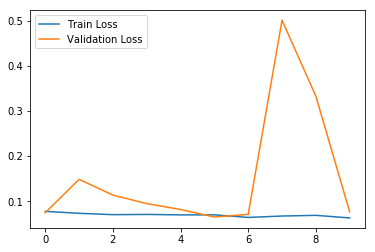

In [0]:
plt.plot(train_running_loss_history, label = 'Train Loss')
plt.plot(validation_running_loss_history, label = 'Validation Loss')
plt.legend()

In [0]:
model.eval()
X_train.size()

torch.Size([1, 1, 572, 572])

In [0]:
out = (y_pred + 0.5).int().float()

In [0]:
print(dice_index(y_train, out))
print(dice_loss(y_train, out))

tensor(0.9691, device='cuda:0')
tensor(0.0314, device='cuda:0')


IndexError: ignored

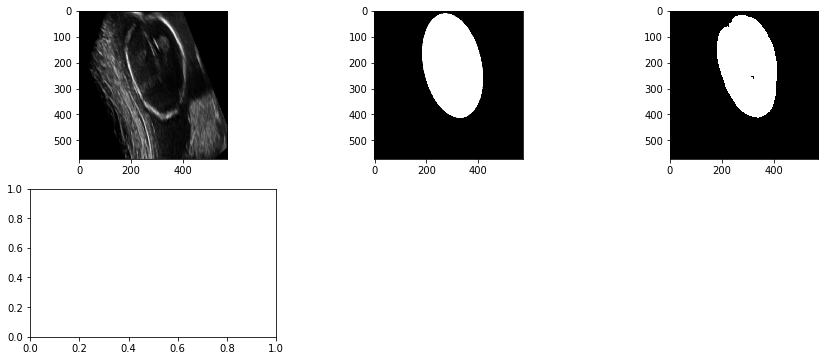

In [0]:
pig = plt.figure(figsize = (15, 6))

a = pig.add_subplot(2, 3, 1)
plt.imshow(im_converterX(X_train[0]))

a = pig.add_subplot(2, 3, 2)
plt.imshow(im_converterY(y_train[0]))

a = pig.add_subplot(2, 3, 3)
plt.imshow(im_converterY(out[0]))


a = pig.add_subplot(2, 3, 4)
plt.imshow(im_converterX(X_train[1]))

a = pig.add_subplot(2, 3, 5)
plt.imshow(im_converterY(y_train[1]))

a = pig.add_subplot(2, 3, 6)
plt.imshow(im_converterY(out[1]))

In [0]:
gg = dice_index(out, y_train)
print(gg)
print(dice_loss(out, y_train))

tensor(0.9691, device='cuda:0')
tensor(0.0314, device='cuda:0')


In [0]:
class HC18_test(Dataset):
    def __init__(self, root_dir, transformX = None):
        self.pixel_file = pd.read_csv(os.path.join(root_dir, 'test_set_pixel_size.csv'))
        self.root_dir = root_dir
        self.transformX = transformX
        
    def __len__(self):
        return len(self.pixel_file)
    
    def __getitem__(self, index):
        imx_name = os.path.join(self.root_dir, 'test_set', self.pixel_file.iloc[index, 0])
        
        imx = Image.open(imx_name)
        
        f_name = self.pixel_file.iloc[index, 0]
        
        if self.transformX :
            imx = self.transformX(imx)
        
        sample = {'image': imx, 'f_name': f_name}
        return sample

In [0]:
test_data = HC18_test('/content/HC18', transformX = tx_X)

In [0]:
test_loader = DataLoader(dataset = test_data, batch_size = 2, shuffle = True)

0 torch.Size([2, 1, 572, 572])


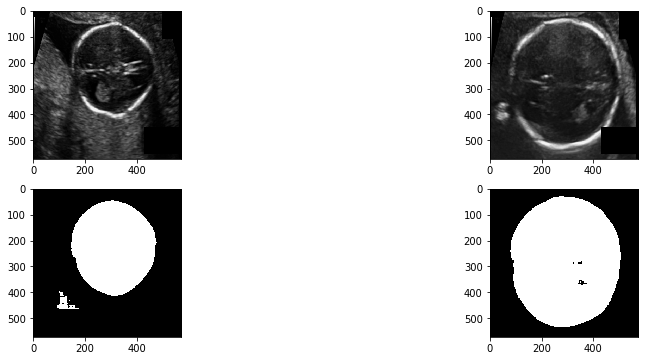

In [0]:
## Here we loop through our train_loader and see the images
## Looks good
fig = plt.figure(figsize = (15,6))
#model.to('cpu')
for ith_batch, sample_batched in enumerate(test_loader):
  
    X_test = sample_batched['image'].to('cuda')
    print(ith_batch, X_test.size())
    
    y_test = (model(X_test) + 0.5).int().float()
    
    
    
    for index in range(2):
        ax = fig.add_subplot(2, 2 , index + 1)  # subplot index starts from 1
        plt.imshow(im_converterX(X_test[index]))
        
        ax  = fig.add_subplot(2, 2, index + 3)
        plt.imshow(im_converterY(y_test[index]))
    break

In [0]:
def avg_dice_index(dataloader):
  
    dice = 0.0
    model.eval()
    with torch.no_grad():
    
        for ith_batch, sample_batched in enumerate(dataloader):
  
            X_train = sample_batched['image'].to('cuda')
            y_train = sample_batched['annotation'].to('cuda')
            
            y_predict = (model(X_train) + 0.5).int().float()
            
            dice += dice_index(y_predict, y_train)
            
            
            
    avg_dice = dice / len(dataloader)
    return avg_dice.item()

In [0]:
avg_dice_index(validation_loader)

0.9379729628562927

In [0]:
avg_dice_index(train_loader)

0.9315618872642517

In [0]:
test_loader = DataLoader(dataset = test_data, batch_size = 1, shuffle = True) # to write image files

## **Warning!!!**
### Your are about to write on drive

In [0]:
transform = transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize((540, 800)),
        transforms.ToTensor()
        ])
    
with torch.no_grad():
      #model.eval()
      for ith_batch , sample in enumerate(test_loader):
        X_test = sample['image'].to('cuda')
        y_pred = (model(X_test) + 0.5).int().float().cpu()
        print(335-ith_batch)
        
        file_names = sample['f_name']
        pankaj = transform(y_pred[0])
        #singh = transform(y_pred[1])
        torchvision.utils.save_image(pankaj , os.path.join('/content/segmented', file_names[0]))
        #torchvision.utils.save_image(singh, os.path.join('/content/drive/My Drive/HC18/test_set', file_names[1].replace('.png','_Annotation.png')))
        
        
        

335
334
333
332
331
330
329
328
327
326
325
324
323
322
321
320
319
318
317
316
315
314
313
312
311
310
309
308
307
306
305
304
303
302
301
300
299
298
297
296
295
294
293
292
291
290
289
288
287
286
285
284
283
282
281
280
279
278
277
276
275
274
273
272
271
270
269
268
267
266
265
264
263
262
261
260
259
258
257
256
255
254
253
252
251
250
249
248
247
246
245
244
243
242
241
240
239
238
237
236
235
234
233
232
231
230
229
228
227
226
225
224
223
222
221
220
219
218
217
216
215
214
213
212
211
210
209
208
207
206
205
204
203
202
201
200
199
198
197
196
195
194
193
192
191
190
189
188
187
186
185
184
183
182
181
180
179
178
177
176
175
174
173
172
171
170
169
168
167
166
165
164
163
162
161
160
159
158
157
156
155
154
153
152
151
150
149
148
147
146
145
144
143
142
141
140
139
138
137
136
135
134
133
132
131
130
129
128
127
126
125
124
123
122
121
120
119
118
117
116
115
114
113
112
111
110
109
108
107
106
105
104
103
102
101
100
99
98
97
96
95
94
93
92
91
90
89
88
87
86
85
84
83
82
81

In [0]:
from google.colab import drive
drive.mount('/content/drive', force_remount = True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
def fit_ellipse(im):    
    imgray = cv2.cvtColor(im,cv2.COLOR_BGR2GRAY)
    ret,thresh = cv2.threshold(imgray,127,255,0)
    im2, contours, hierarchy = cv2.findContours(thresh,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)
    contour_sizes = [len(contour) for contour in contours]
    ellipse = cv2.fitEllipse(contours[np.argmax(contour_sizes)])
    return ellipse

In [0]:
df_pixel_size = pd.read_csv('/content/HC18/test_set_pixel_size.csv')
submission = {'filename': [], 'center_x_mm': [], 'center_y_mm': [], 'semi_axes_a_mm': [],
             'semi_axes_b_mm': [], 'angle_rad': [], 'Index': []}

file_names = sorted([file for _,_,files in os.walk('/content/segmented/') for file in files])

for i, file_name in enumerate(file_names):
    im = cv2.imread('/content/segmented/'+file_name)
   # file_name = file_name.replace('_Segmented', '')
    ellipse = fit_ellipse(im)
    im_mask = cv2.ellipse(np.zeros_like(im),ellipse,(255,255,255),-1)
    image_name = file_name.split('.')[0] + '_Annotation_fit.png'
    #cv2.imwrite('/content/drive/My Drive/HC18/test_set/'+image_name, im_mask)
    
    pixel_size = df_pixel_size.loc[df_pixel_size['filename'] == file_name, 'pixel size(mm)'].iloc[0]
    submission['filename'].extend([file_name])
    submission['Index'].extend([int(file_name.split('_')[0])])
    center_x,  center_y = ellipse[0]
    submission['center_x_mm'].extend([pixel_size*center_x])
    submission['center_y_mm'].extend([pixel_size*center_y])
    semi_axes_b, semi_axes_a = ellipse[1]
    if semi_axes_b > semi_axes_a:
        semi_axes_b = semi_axes_b + semi_axes_a
        semi_axes_a = semi_axes_b - semi_axes_a
        semi_axes_b -= semi_axes_a
    submission['semi_axes_a_mm'].extend([semi_axes_a*pixel_size/2])
    submission['semi_axes_b_mm'].extend([semi_axes_b*pixel_size/2])
    angle = ellipse[2]
    if angle < 90:
        angle += 90
    else:
        angle -= 90
    submission['angle_rad'].extend([np.deg2rad(angle)])
    
submission = pd.DataFrame(submission)
submission = submission[['filename', 'center_x_mm', 'center_y_mm', 
                         'semi_axes_a_mm', 'semi_axes_b_mm', 'angle_rad', 'Index']]    
submission = submission.sort_values(['Index'])
submission = submission.drop('Index', axis=1)
submission.to_csv("seventh_submit_data_aug.csv", index=False)

In [0]:
q = pd.read_csv('/content/seventh_submit_data_aug.csv')

In [0]:
len(q)

335